In [294]:
import os
import sys
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Bio.PDB.Polypeptide as pp
sys.path.append('/Users/macbook/Documents/GitHub/perturbation-networks-get-data')
from getmutations import MutationsDict, GetMutations
%matplotlib inline

In [2]:
AA = list(pp.aa1)

In [3]:
path = "/Users/macbook/Documents/perturbation-networks/dms_data"
protein_path = "/Users/macbook/Documents/perturbation-networks/proteins"

In [146]:
pd.set_option('display.max_columns', None)

In [4]:
def PlotHeatmap(dataframe, save_as=None, vmin=None, vmax=None):
    """Plot heatmap of dataframe values.
    
    Parameters:
        dataframe: data to plot
        save_as: name of file to save. If None, image is not saved
        vmin, vmax: min and max values for colorscale
    """
    # Set missing values gray 
    sns.set(rc={'axes.facecolor':'94A3A8'})
    # Set size to match dataframe dimensions
    w = len(dataframe.columns)
    h = len(dataframe.index)
    ratio = w//h
    plt.figure(figsize=(10*ratio,10))
    heatmap = sns.heatmap(dataframe, cmap='RdBu_r', center=0, cbar=True, square=True, vmin=vmin, vmax=vmax)
    if save_as:
        fig = heatmap.get_figure()
        fig.savefig(f'{save_as}.png')
    return

## Deep Mutational Scanning Data

Processing different formats of deep mutational scanning data into DataFrames, with columns being positions, index being aminoacids.

### 1be9

In [5]:
# Positions from PDB file 
pdb_file = os.path.join(protein_path, '1be9/1be9.pdb')
mutations = MutationsDict(pdb_file, positions=[('A', 311, 393)])
mutations = [mutation[0]+mutation[2:] for mutation in mutations.keys()]

In [6]:
functional_1be9 = pd.read_csv(os.path.join(path, "1be9_functional.csv"), names=mutations)
functional_1be9.index = AA

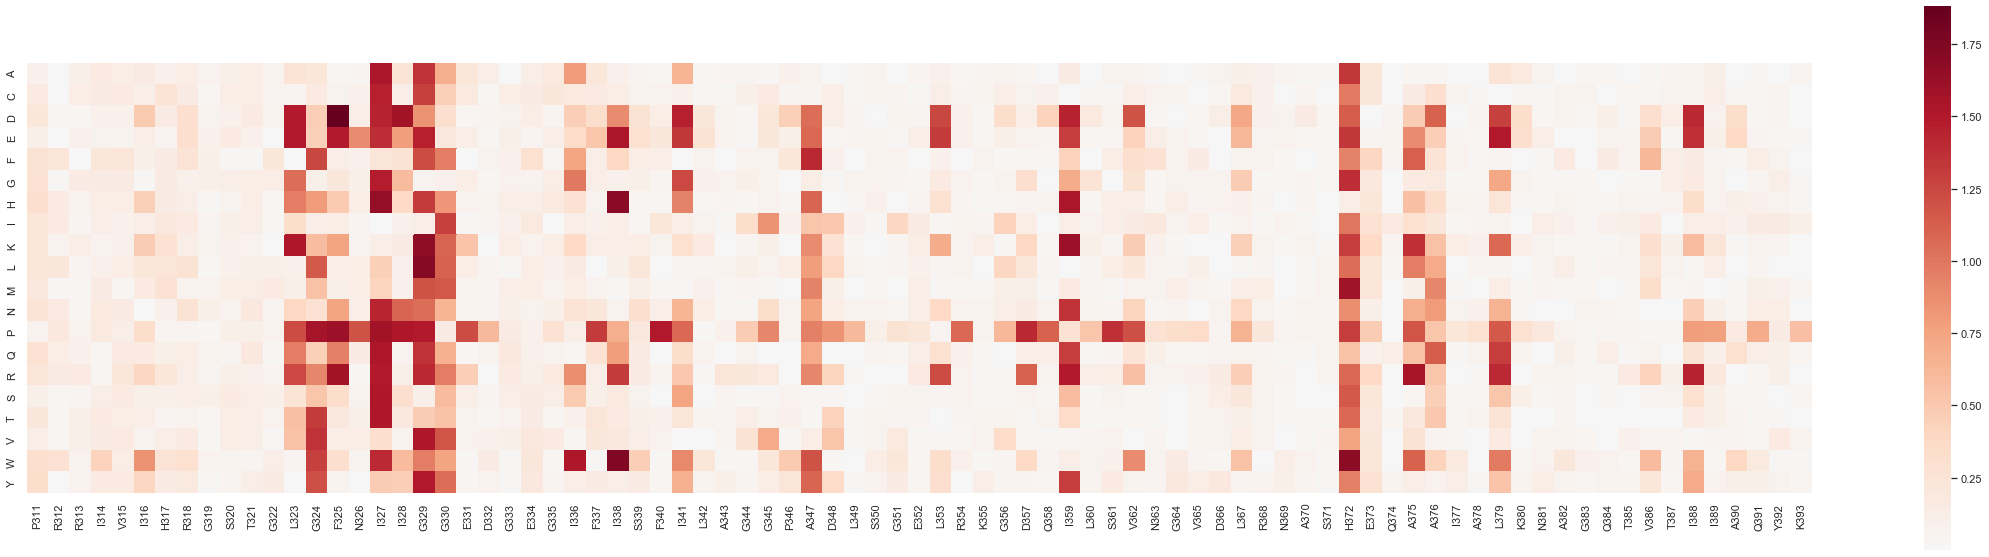

In [7]:
PlotHeatmap(functional_1be9)

### 1d5r

In [8]:
file = os.path.join(path, "1d5r_functional.csv")
funct_1d5r = pd.read_csv(file, header=0, index_col=0, usecols=[0, 6, 8, 10])

In [9]:
# Use index to get position list 
positions = []
index_list = list(funct_1d5r.index)
for index in index_list:
    #index has format A#A
    position = index[:-1]
    positions.append(position)
# Remove duplicates and sort according to position number
positions = list(set(positions))
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons, '~' for deletions
#AAstop = AA + ['*', '~']
functional_1d5r = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [10]:
# If high confidence, we keep the cum_score, else, we keep imputed_score
for index, row in funct_1d5r.iterrows():
    original = index[:-1]
    mutation = index[-1]
    if mutation.isalpha():
        if row[1] == 'VERDADERO':
            functional_1d5r.at[mutation, original] = funct_1d5r.at[index, 'Cum_score']
        else:
            functional_1d5r.at[mutation, original] = funct_1d5r.at[index, 'Imputed_Score']

In [11]:
# Only keep positions for which we also have pdb data
pdb_file = os.path.join(protein_path, '1d5r/1d5r.pdb')
mutations = list(MutationsDict(pdb_file).keys())
mutations = [mutation[0]+mutation[2:] for mutation in mutations] # remove chain id 
new_positions = [prefix for prefix in positions if prefix in mutations]
functional_1d5r = functional_1d5r[new_positions]

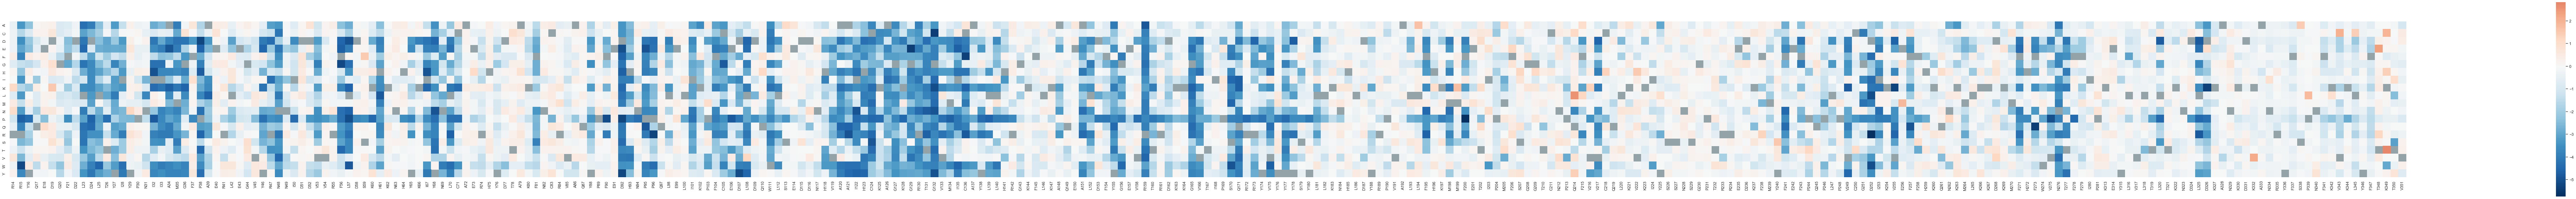

In [12]:
PlotHeatmap(functional_1d5r)

### 3dqw

In [13]:
funct_3dqw = pd.read_csv(os.path.join(path, "3dqw-functional.csv"), index_col=0)
funct_3dqw = funct_3dqw[['Scores']]

In [14]:
# Functional scores are the negative of the scores in the file 
funct_3dqw['Scores'] = funct_3dqw['Scores'].apply(lambda x:-x)

In [15]:
# Use index to get position list 
positions = []
index_list = list(funct_3dqw.index)
for index in index_list:
    # Index has format p.AAA#AAA
    original = pp.three_to_one(index[2:5].upper())
    position = original+index[5:-3]
    positions.append(position)
# Remove duplicates and sort according to position number
positions = list(set(positions))
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons
#AAstop = AA + ['*']
functional_3dqw = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [16]:
for index, row in funct_3dqw.iterrows():
    #index has format p.AAA#AAA
    original = index[2:5].upper()
    mutation = index[-3:].upper()
    if pp.is_aa(mutation):
        original = pp.three_to_one(original)
        mutation = pp.three_to_one(mutation)
        position = original+index[5:-3]
        functional_3dqw.at[mutation, position] = row['Scores']
    #else:
    #    original = pp.three_to_one(original)
    #    position = original+index[5:-3]
    #    functional_3dqw.at['*', position] = row['Scores']

In [17]:
# After checking both types of data, we found that the numbering of positions does not match, we adjust the numbering 
# to match PDB file, subtracting 3 from each position
aligned_positions = [position[0]+str(int(position[1:])-3) for position in positions]
functional_3dqw.columns = aligned_positions

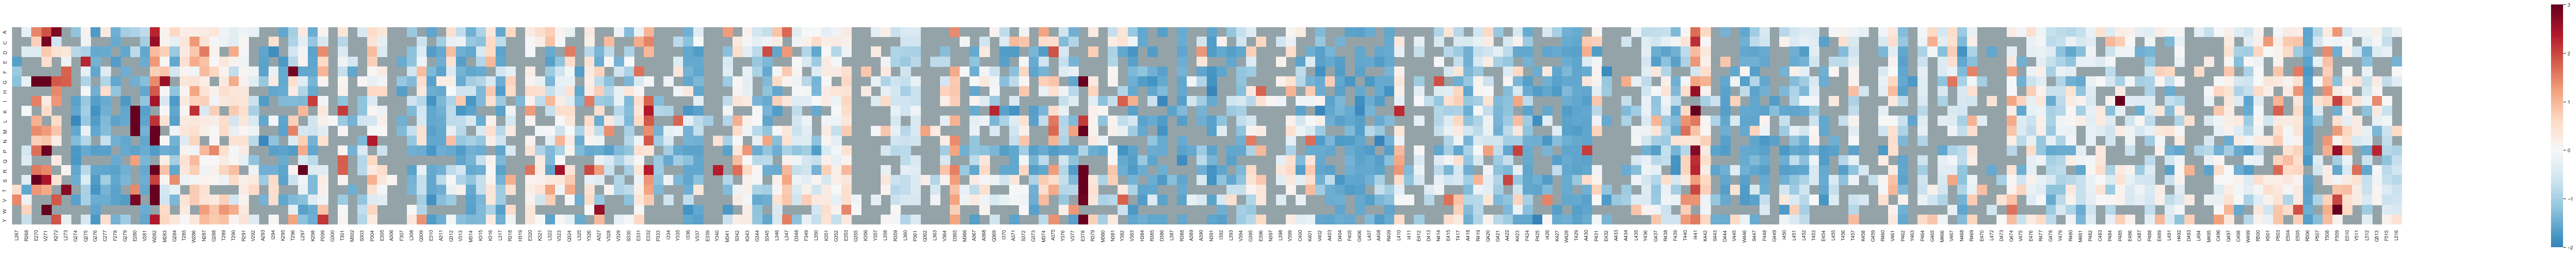

In [525]:
PlotHeatmap(functional_3dqw, vmin=-2, vmax=3)

### 4bz3

In [19]:
file = os.path.join(path, "4bz3_functional.csv")
# We are keeping selection with 128ug/mL AMP at 37C
funct_4bz3 = pd.read_csv(file, header=0, usecols=[1,2,3,12]) 

In [20]:
# Use wt residue and position to get position list 
positions = set()
for index, row in funct_4bz3.iterrows():
    positions.add(row[0]+str(row[1]))
positions = list(positions)
# Sort according to position number
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons
#AAstop = AA + ['*']
functional_4bz3 = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [21]:
for index, row in funct_4bz3.iterrows():
    original = row['wt residue']+str(row['position'])
    mutation = row['variant residue']
    if mutation.isalpha():
        functional_4bz3.at[mutation, original] = funct_4bz3.at[index, '128ug/mL_AMP_37C']

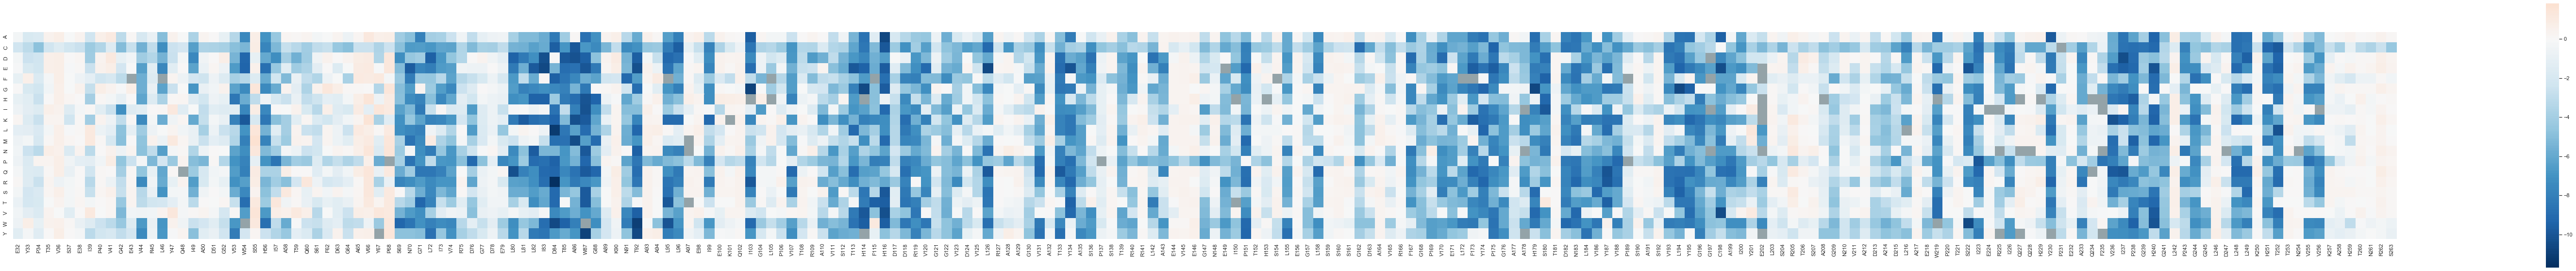

In [526]:
PlotHeatmap(functional_4bz3) #vmin=-4, vmax=4)

### 1nd4

In [505]:
def GetDataFrame(file):
    """Get dataframe and fix format issues."""
    df = pd.read_csv(file, sep='\t', skiprows=(0), lineterminator='\n', header = [1,2], index_col = [0])
    df.columns = pd.MultiIndex.from_tuples([(int(ix[0]), ix[1].rstrip()) for ix in df.columns.tolist()])
    return df
# mi yo del pasado escribió eso, no recuerdo por qué necesitaba todo eso para que sirviera, pero es por el formato de 
# los txt

In [506]:
file = os.path.join(path, "1nd4-functional/KKA2_S1_Kan12_L1.aadiff.txt")
# We are keeping selection with 1:2 kanamycin
funct_1nd4 = GetDataFrame(file) 
funct_1nd4 = funct_1nd4.drop(funct_1nd4.index[range(20,40)])

In [507]:
funct_1nd4.at['Delta-G', (1, 'M')] = np.NaN # Removing outlier value of 72202

In [508]:
# Use header to get position list 
positions = [col[1]+str(col[0]) for col in funct_1nd4.columns]
# AA list as index
functional_1nd4 = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [522]:
for index in funct_1nd4.index:
    for col in funct_1nd4.columns:
        position = col[1]+str(col[0])
        mutation = index[-1]
        value = funct_1nd4.at[index, col]
        functional_1nd4.at[mutation, position] = np.log2(value) #np.log10(value)

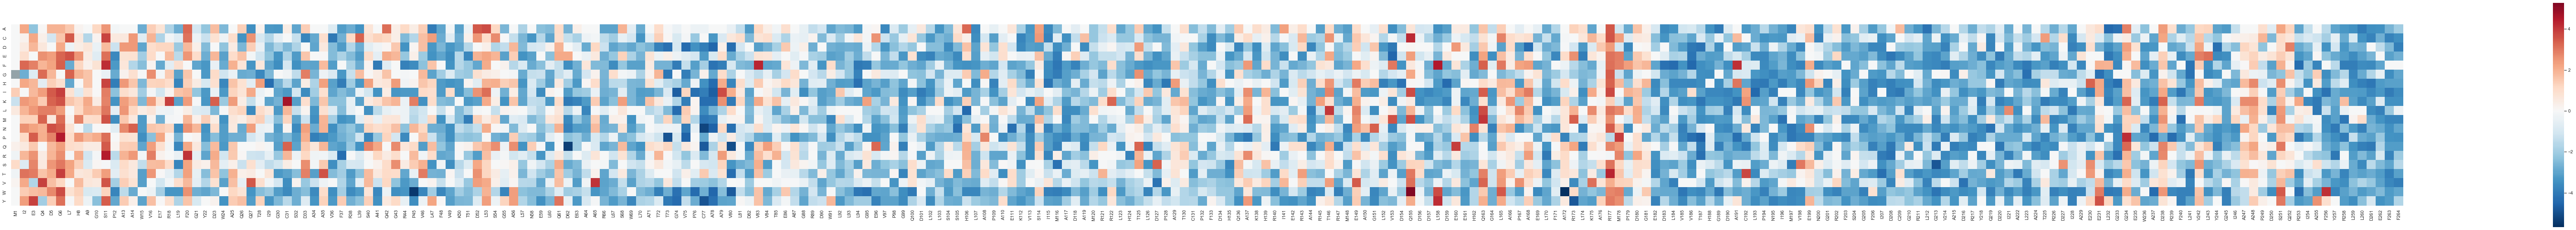

In [523]:
PlotHeatmap(functional_1nd4)

## Perturbation Network Data

In [41]:
data_path = os.path.join(protein_path, 'data')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
functional_data = {'1be9':functional_1be9, '1nd4':functional_1nd4, '1d5r':functional_1d5r, '3dqw':functional_3dqw, 
                  '4bz3':functional_4bz3}

First, fix functional DataFrames so they only have positions for which both functional and network data is available.

In [42]:
def CheckData(protein):
    """Returns list of positions (without chain id) in protein for which both DMS and network data is available."""
    functional_columns = set(functional_data[protein].columns)
    # Sample network file
    file = os.path.join(data_path, f'{protein}/{protein}_3.0_weight.csv')
    df = pd.read_csv(file, header=0)
    df_columns = list(df.columns)
    # Since network data has chain id, we need a set of positions without it
    network_columns = set([column[0]+column[2:] for column in df_columns])
    positions = list(network_columns.intersection(functional_columns))
    positions.sort(key = lambda x:int(x[1:]))
    return positions

In [60]:
# Remove columns without both kinds of data
for protein in proteins:
    positions = CheckData(protein)
    df = functional_data[protein]
    df = df[positions]
    # Save new data in dictionary again
    functional_data[protein] = df
    # Save with absolute value to focus only on functional change
    functional_data_abs[protein] = df.apply(np.abs)

# Rewrite functional_protein dataframes 
functional_1be9 = functional_data['1be9']
functional_1nd4 = functional_data['1nd4']
functional_1d5r = functional_data['1d5r']
functional_3dqw = functional_data['3dqw']
functional_4bz3 = functional_data['4bz3']

In [61]:
def AverageOverChains(protein, threshold, measure):
    """If protein has multiple identical chains, return DataFrame with average values per position. Returns df without
    chain names in columns. """
    file = os.path.join(data_path, f"{protein}/{protein}_{threshold}_{measure}.csv")
    df = pd.read_csv(file, header=0)
    df.index = AA
    # Get how many chains from column names 
    column_names = list(df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction, from modified functional files
    positions = list(functional_data[protein].columns)
    #positions = list(set([c[0]+c[2:] for c in column_names]))
    #positions.sort(key = lambda x:int(x[1:]))
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in df.columns:
                    values.append(df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [62]:
def ReadNetworkCSV(protein, threshold, measure, average=True):
    """Return DataFrame from corresponding CSV. If average, apply AverageOverChains and only show mutations for which 
    both kinds data is available."""
    file = os.path.join(data_path, f"{protein}/{protein}_{threshold}_{measure}.csv")
    # Check that file has same columns as functional
    if average:
        functional = functional_data[protein]
        df = AverageOverChains(protein, threshold, measure)
        positions = list(functional.columns)
        df = df[positions]
    else:
        df = pd.read_csv(file, header=0)
    df.index = AA
    return df

In [350]:
def SampleSpearmanR(protein, average=True, data=functional_data, thresholds=sample_thresholds):
    """Return DataFrame with Spearman correlation coefficient between functional and network data for mean score 
    over aminoacids."""
    functional_df = data[protein]
    functional = list(functional_df.mean())
    spearman = pd.DataFrame(index=thresholds, columns=measures)
    for measure in measures:
        for threshold in thresholds:
            df = ReadNetworkCSV(protein, threshold, measure, average=average)
            compare = list(df.mean())
            spearman.at[threshold, measure] = round(sp.stats.spearmanr(functional, compare)[0], 3)
    spearman.loc['Mean'] = spearman.mean()
    return spearman

In [252]:
def SamplePearsonR(protein, average=True, data=functional_data, thresholds=sample_thresholds):
    """Return DataFrame with Pearson correlation coefficient between functional and network data for mean score 
    over aminoacids."""
    functional_df = data[protein]
    functional = list(functional_df.mean())
    pearson = pd.DataFrame(index=thresholds, columns=measures)
    for measure in measures:
        for threshold in thresholds:
            df = ReadNetworkCSV(protein, threshold, measure, average=average)
            compare = list(df.mean())
            pearson.at[threshold, measure] = round(sp.stats.pearsonr(functional, compare)[0], 3)
    pearson.loc['Mean'] = pearson.mean()
    return pearson

In [141]:
SampleSpearmanR('3dqw', absolute=True)

,nodes,edges,weight,distance
3.0,0.171,0.165,0.148,0.147
4.0,0.323,0.323,0.315,0.218
5.0,0.371,0.349,0.301,0.18
6.0,0.358,0.342,0.311,0.183
7.0,0.382,0.349,0.326,0.206
8.0,0.408,0.359,0.343,0.197
9.0,0.416,0.361,0.36,0.184
10.0,0.419,0.377,0.377,0.19
Mean,0.356,0.328125,0.310125,0.188125


In [140]:
SampleSpearmanR('3dqw')

,nodes,edges,weight,distance
3.0,-0.19,-0.173,-0.191,-0.148
4.0,-0.35,-0.359,-0.301,-0.204
5.0,-0.385,-0.376,-0.294,-0.166
6.0,-0.397,-0.379,-0.324,-0.15
7.0,-0.443,-0.402,-0.35,-0.149
8.0,-0.464,-0.411,-0.375,-0.212
9.0,-0.489,-0.423,-0.399,-0.215
10.0,-0.489,-0.44,-0.426,-0.22
Mean,-0.400875,-0.370375,-0.3325,-0.183


Las primeras correlaciones, con los promedios por posición y tomando solo una muestra de thresholds sugieren que al distancia no es tan buena medida como las otras tres, pero es interesante que varía bastante. También destaca que 3.0 da puntajes mucho más bajos que los otros thresholds de muestra, y que tres proteínas tienen valores más altos (alrededor de 0.62), mientras que las otras dos tienen valores más bajos. Para 3dqw, podría ser que faltan algunos valores de datos funcionales. 

In [106]:
correlations = ['Spearman', 'Pearson']
multi_index = [x for x in itertools.product(correlations, measures)]
sample_correlations = pd.DataFrame(columns=pd.MultiIndex.from_tuples(multi_index))
for protein in proteins:
    line = list(SampleSpearmanR(protein).loc['Mean'])+list(SamplePearsonR(protein).loc['Mean'])
    sample_correlations.loc[protein] = line

In [107]:
sample_correlations

Spearman                                 Pearson                      \
         nodes     edges    weight  distance     nodes     edges    weight   
1be9  0.446625  0.451125  0.437250  0.096875  0.349750  0.424750  0.396000   
1d5r -0.622000 -0.600750 -0.569625 -0.376000 -0.647250 -0.628125 -0.570750   
1nd4 -0.642000 -0.616125 -0.590500 -0.453625 -0.573500 -0.541875 -0.504750   
3dqw -0.400875 -0.370375 -0.332500 -0.183000 -0.341125 -0.329500 -0.291625   
4bz3 -0.619500 -0.553250 -0.556750 -0.279250 -0.620625 -0.548500 -0.516250   

                
      distance  
1be9  0.067000  
1d5r -0.342375  
1nd4 -0.431500  
3dqw -0.132250  
4bz3 -0.247750

In [111]:
correlations = ['Spearman', 'Pearson']
multi_index = [x for x in itertools.product(correlations, measures)]
sample_correlations = pd.DataFrame(columns=pd.MultiIndex.from_tuples(multi_index))
for protein in proteins:
    new_thresholds = [i for i in np.linspace(4, 10, 7)]
    line = list(SampleSpearmanR(protein, thresholds=new_thresholds).loc['Mean']) +\
            list(SamplePearsonR(protein, thresholds=new_thresholds).loc['Mean'])
    sample_correlations.loc[protein] = line

In [112]:
sample_correlations

Spearman                                 Pearson                      \
         nodes     edges    weight  distance     nodes     edges    weight   
1be9  0.479714  0.478286  0.460000  0.082571  0.370000  0.449143  0.408429   
1d5r -0.657000 -0.632143 -0.598000 -0.381286 -0.681143 -0.658286 -0.595286   
1nd4 -0.663714 -0.634143 -0.603857 -0.455143 -0.589714 -0.556143 -0.520143   
3dqw -0.431000 -0.398571 -0.352714 -0.188000 -0.368857 -0.355143 -0.304714   
4bz3 -0.663429 -0.583143 -0.580143 -0.265429 -0.660857 -0.573429 -0.535286   

                
      distance  
1be9  0.054857  
1d5r -0.342714  
1nd4 -0.428714  
3dqw -0.132571  
4bz3 -0.238571

In [188]:
# Only keep positions for 3dqw for which there's data of at least 15 mutations
# Positions reduced from 242 to 129
filtered_3dqw = functional_3dqw.copy()
filtered_3dqw = filtered_3dqw.dropna(axis=1, thresh=15)# Remove columns with less than 15 non NaN values.
positions = list(filtered_3dqw.columns)
# Run Pearson and Spearman for sample thresholds to compare 
filtered_spearman = pd.DataFrame(index=sample_thresholds, columns=measures)
filtered_pearson = pd.DataFrame(index=sample_thresholds, columns=measures)
for measure in measures:
    for threshold in sample_thresholds:
        df = ReadNetworkCSV('3dqw', threshold, measure)
        df = df[positions]
        network_mean = list(df.mean())
        filtered_mean = list(filtered_3dqw.mean())
        filtered_pearson.at[threshold, measure] = round(sp.stats.pearsonr(network_mean, filtered_mean)[0], 3)
        filtered_spearman.at[threshold, measure] = round(sp.stats.spearmanr(network_mean, filtered_mean)[0], 3)
filtered_pearson.loc['Mean'] = filtered_pearson.mean()
filtered_spearman.loc['Mean'] = filtered_spearman.mean()

In [189]:
filtered_spearman

,nodes,edges,weight,distance
3.0,-0.235,-0.217,-0.243,-0.173
4.0,-0.405,-0.403,-0.337,-0.264
5.0,-0.415,-0.412,-0.348,-0.258
6.0,-0.457,-0.434,-0.39,-0.267
7.0,-0.498,-0.465,-0.409,-0.217
8.0,-0.493,-0.458,-0.435,-0.256
9.0,-0.512,-0.465,-0.445,-0.27
10.0,-0.514,-0.476,-0.466,-0.26
Mean,-0.441125,-0.41625,-0.384125,-0.245625


In [137]:
SampleSpearmanR('3dqw')

,nodes,edges,weight,distance
3.0,-0.19,-0.173,-0.191,-0.148
4.0,-0.35,-0.359,-0.301,-0.204
5.0,-0.385,-0.376,-0.294,-0.166
6.0,-0.397,-0.379,-0.324,-0.15
7.0,-0.443,-0.402,-0.35,-0.149
8.0,-0.464,-0.411,-0.375,-0.212
9.0,-0.489,-0.423,-0.399,-0.215
10.0,-0.489,-0.44,-0.426,-0.22
Mean,-0.400875,-0.370375,-0.3325,-0.183


Mejora un poco, pero no sé si sea exactamente eso lo que nos está dando valores bajos, al menos en ese caso. Probaremos ahora correlaciones por columna, primero solo para threshold = 5.0. 

In [253]:
def SpearmanByColumn(protein, threshold=5.0, data=functional_data):
    """Returns DataFrame with Spearman correlation value for each column in protein. """
    functional_df = data[protein]
    positions = list(functional_df.columns)
    by_column = pd.DataFrame(index=measures, columns=positions)
    for measure in measures:
        network_df = ReadNetworkCSV(protein, threshold, measure)
        for position in positions:
            network_column = list(network_df[position])
            functional_column = list(functional_df[position])
            by_column.at[measure, position] = round(sp.stats.spearmanr(network_column, functional_column, 
                                                                        nan_policy='omit')[0], 3)
    return by_column

In [180]:
SpearmanByColumn('1d5r')

,R14,R15,Y16,Q17,E18,D19,G20,F21,D22,L23,D24,L25,T26,Y27,I28,Y29,P30,N31,I32,I33,A34,M35,G36,F37,P38,A39,E40,R41,L42,E43,G44,V45,Y46,R47,N48,N49,I50,D51,D52,V53,V54,R55,F56,L57,D58,S59,K60,H61,K62,N63,H64,Y65,K66,I67,Y68,N69,L70,C71,A72,E73,R74,H75,Y76,D77,T78,A79,K80,F81,N82,C83,R84,V85,A86,Q87,Y88,P89,F90,E91,D92,H93,N94,P95,P96,Q97,L98,E99,L100,I101,K102,P103,F104,C105,E106,D107,L108,D109,Q110,W111,L112,S113,E114,D115,D116,N117,H118,V119,A120,A121,I122,H123,C124,K125,A126,G127,K128,G129,R130,T131,G132,V133,M134,I135,C136,A137,Y138,L139,L140,H141,R142,G143,K144,F145,L146,K147,A148,Q149,E150,A151,L152,D153,F154,Y155,G156,E157,V158,R159,T160,R161,D162,K163,K164,G165,V166,T167,I168,P169,S170,Q171,R172,R173,Y174,V175,Y176,Y177,Y178,S179,Y180,L181,L182,K183,N184,H185,L186,D187,Y188,R189,P190,V191,A192,L193,L194,F195,H196,K197,M198,M199,F200,E201,T202,I203,P204,M205,F206,S207,G208,G209,T210,C211,N212,P213,Q214,F215,V216,V217,C218,Q219,L220,K221,V222,K223,I224,Y225,S226,S227,N228,S229,G230,P231,T232,R233,R234,E235,D236,K237,F238,M239,Y240,F241,E242,F243,P244,Q245,P246,L247,P248,V249,C250,G251,D252,I253,K254,V255,E256,F257,F258,H259,K260,Q261,N262,K263,M264,L265,K266,K267,D268,K269,M270,F271,H272,F273,W274,V275,N276,T277,F278,F279,I280,P281,K313,E314,Y315,L316,V317,L318,T319,L320,T321,K322,N323,D324,L325,D326,K327,A328,N329,K330,D331,K332,A333,N334,R335,Y336,F337,S338,P339,N340,F341,K342,V343,K344,L345,Y346,F347,T348,K349,T350,V351
nodes,-0.208,-0.043,-0.484,0.099,-0.177,-0.132,-0.209,-0.466,0.12,-0.457,-0.628,0.079,0.075,-0.643,-0.445,0.316,-0.269,-0.032,-0.432,-0.602,-0.648,-0.177,-0.641,-0.132,-0.023,-0.487,-0.363,-0.463,-0.125,0.002,-0.426,-0.072,-0.189,0.546,0.074,-0.515,0.201,0.555,-0.251,-0.252,-0.225,-0.356,-0.058,-0.114,-0.134,0.137,-0.347,-0.042,-0.326,-0.03,-0.375,0.123,-0.409,-0.58,-0.228,-0.171,-0.306,-0.32,0.07,-0.191,0.103,-0.048,-0.127,-0.158,-0.08,-0.132,-0.146,-0.113,-0.388,-0.298,0.067,-0.149,-0.091,-0.242,-0.385,-0.169,-0.165,-0.14,0.266,-0.243,-0.12,-0.717,-0.567,-0.332,-0.059,-0.023,0.085,-0.108,0.281,-0.07,-0.322,-0.134,-0.252,-0.502,0.197,-0.062,-0.117,-0.082,-0.349,-0.315,-0.07,0.127,0.03,0.025,-0.341,-0.378,-0.626,-0.49,-0.073,-0.429,0.348,-0.116,-0.348,0.212,-0.461,-0.32,-0.047,-0.557,0.036,-0.619,-0.05,-0.337,-0.546,-0.688,0.021,-0.12,-0.522,-0.061,-0.099,-0.327,-0.335,-0.345,-0.154,-0.37,-0.118,-0.226,0.287,-0.632,-0.289,-0.265,-0.283,-0.515,-0.331,0.394,-0.053,0.021,-0.33,-0.086,-0.152,-0.023,0.137,-0.347,-0.373,0.156,-0.057,0.227,-0.11,0.062,-0.313,-0.513,-0.379,-0.702,0.62,-0.653,-0.467,-0.176,-0.13,-0.267,-0.22,0.186,-0.113,0.135,-0.124,0.044,-0.467,-0.014,0.062,0.081,0.1,-0.067,-0.031,0.363,-0.313,0.032,-0.008,-0.248,0.057,-0.521,-0.311,-0.314,0.129,-0.107,-0.063,0.136,-0.116,-0.329,-0.237,0.102,-0.204,-0.147,0.159,-0.063,0.123,-0.323,-0.209,0.175,0.289,-0.105,-0.118,0.023,-0.341,-0.514,-0.019,0.028,0.115,-0.005,0.118,-0.422,-0.231,-0.091,-0.499,0.164,0.395,0.061,0.166,0.331,0.018,0.007,0.414,-0.179,0.196,0.068,0.111,-0.053,-0.249,-0.479,0.14,-0.006,-0.586,0.231,-0.412,-0.113,0.398,0.109,-0.034,-0.161,-0.017,-0.323,0.218,-0.194,-0.146,0.013,-0.072,0.387,-0.028,0.184,0.293,0.467,0.109,0.135,-0.348,0.065,-0.104,-0.396,-0.294,-0.129,0.168,0.015,0.083,-0.435,-0.266,-0.602,0.087,-0.063,-0.244,-0.134,-0.108,-0.297,0.228,-0.087,-0.025,0.046,0.008,-0.239,-0.04,-0.093,0.009,-0.423,0.356,-0.253,-0.353,-0.391,-0.213,-0.3,-0.123,-0.072,-0.159,-0.205,-0.174,-0.082,-0.277,0.226,-0.012,-0.097,-0.101,-0.584,-0.303
edges,-0.296,-0.05,-0.538,0.123,-0.244,-0.103,-0.319,-0.404,0.072,-0.488,-0.68,0.041,-0.025,-0.661,-0.418,0.349,-0.205,-0.069,-0.477,-0.441,-0.642,-0.082,-0.577,0.024,-0.097,-0.321,-0.334,-0.463,-0.109,0.002,-0.373,-0.061,-0.166,0.571,0.121,-0.479,0.125,0.556,-0.273,-0.297,-0.229,-0.548,-0.075,-0.142,-0.257,0.024,-0.377,-0.065,-0.354,-0.032,-0.432,0.042,-0.225,-0.497,-0.287,-0.067,-0.286,-0.412,-0.018,-0.328,-0.044,-0.048,-0.253,-0.143,-0.078,-0.161,-0.116,-0.122,-0.353,-0.381,0.09,-0.138,-0.034,-0.263,-0

In [147]:
SpearmanByColumn('1be9')

,P311,R312,R313,I314,V315,I316,H317,R318,G319,S320,T321,G322,L323,G324,F325,N326,I327,I328,G329,G330,E331,D332,G333,E334,G335,I336,F337,I338,S339,F340,I341,L342,A343,G344,G345,P346,A347,D348,L349,S350,G351,E352,L353,R354,K355,G356,D357,Q358,I359,L360,S361,V362,N363,G364,V365,D366,L367,R368,N369,A370,S371,H372,E373,Q374,A375,A376,I377,A378,L379,K380,N381,A382,G383,Q384,T385,V386,T387,I388,I389,A390,Q391,Y392,K393
nodes,0.096,-0.316,-0.572,0.439,0.005,0.489,-0.219,0.058,-0.422,-0.134,-0.32,0.214,-0.151,0.578,0.17,-0.061,0.156,0.34,0.494,0.29,0.082,0.152,-0.071,0.311,-0.044,0.371,0.04,0.4,0.346,0.526,0.209,-0.128,-0.329,0.186,0.258,0.17,0.655,0.254,0.143,0.134,0.276,-0.12,-0.122,-0.09,-0.268,0.259,0.341,-0.058,0.072,0.065,0.421,0.142,0.238,0.639,0.041,-0.06,0.278,-0.383,0.166,0.233,0.455,0.062,-0.022,-0.047,0.662,-0.293,-0.298,0.189,0.196,-0.206,0.223,-0.042,-0.055,0.021,0.118,0.426,0.196,0.39,-0.193,0.221,0.08,-0.245,0.36
edges,0.022,-0.45,-0.564,0.427,-0.022,0.504,-0.238,0.053,-0.414,-0.126,-0.309,0.236,-0.146,0.462,0.157,-0.143,0.079,0.232,0.422,0.393,0.069,0.152,0.045,0.359,-0.042,0.406,-0.101,0.377,0.372,0.515,0.219,-0.124,-0.313,-0.01,0.211,0.2,0.668,0.187,0.143,0.154,0.276,-0.12,-0.067,-0.112,-0.137,0.335,0.294,-0.032,0.099,0.185,0.467,0.058,0.338,0.648,0.041,-0.096,0.151,-0.341,0.166,0.21,0.202,0.116,-0.044,-0.045,0.729,-0.249,-0.179,0.238,0.186,-0.13,0.23,0.134,-0.045,0.021,0.064,0.395,0.157,0.384,-0.01,0.212,0.136,-0.278,0.453
weight,0.355,-0.329,-0.504,0.175,-0.005,0.334,-0.156,-0.166,-0.243,-0.684,-0.234,0.223,-0.298,0.389,-0.128,-0.231,0.129,0.29,0.534,0.438,-0.503,0.276,-0.002,0.296,-0.377,0.526,0.037,0.387,0.376,0.399,0.342,-0.169,-0.207,0.581,0.413,0.159,0.747,-0.141,-0.169,0.254,0.356,-0.414,0.041,-0.029,-0.205,-0.201,0.408,-0.186,0.271,0.099,0.494,0.467,-0.324,0.551,0.245,0.27,0.229,-0.284,0.456,0.137,0.152,0.162,-0.067,0.089,0.682,0.029,-0.21,0.26,0.153,0.053,0.168,0.474,-0.22,-0.115,0.205,0.585,0.395,0.408,-0.087,0.387,0.081,-0.217,0.474
distance,0.05,-0.182,-0.591,0.223,0.104,0.327,0.056,0.156,-0.352,-0.082,-0.345,-0.026,-0.219,0.693,0.072,-0.01,0.073,0.352,0.476,0.206,-0.224,0.179,-0.1,0.505,-0.256,0.205,0.033,0.445,0.397,0.292,0.129,-0.229,-0.371,0.103,0.264,0.081,0.494,-0.053,-0.219,0.071,0.11,0.035,0.026,0.045,-0.26,0.206,0.167,0.07,0.226,-0.109,0.166,0.23,0.409,0.42,-0.016,-0.043,0.416,0.172,0.11,0.236,0.323,0.176,0.092,-0.116,0.36,0.161,-0.008,0.241,0.045,-0.333,0.266,0.336,0.122,0.162,0.488,0.179,0.361,0.448,0.075,0.37,0.179,-0.218,0.489


In [178]:
SpearmanByColumn('4bz3')

,E32,Y33,P34,T35,V36,S37,E38,I39,P40,V41,G42,E43,V44,R45,L46,Y47,Q48,I49,A50,D51,G52,V53,W54,S55,H56,I57,A58,T59,Q60,S61,F62,D63,G64,A65,V66,Y67,P68,S69,N70,G71,L72,I73,V74,R75,D76,G77,D78,E79,L80,L81,L82,I83,D84,T85,A86,W87,G88,A89,K90,N91,T92,A93,A94,L95,L96,A97,E98,I99,E100,K101,Q102,I103,G104,L105,P106,V107,T108,R109,A110,V111,S112,T113,H114,F115,H116,D117,D118,R119,V120,G121,G122,V123,D124,V125,L126,R127,A128,A129,G130,V131,A132,T133,Y134,A135,S136,P137,S138,T139,R140,R141,L142,A143,E144,V145,E146,G147,N148,E149,I150,P151,T152,H153,S154,L155,E156,G157,L158,S159,S160,S161,G162,D163,A164,V165,R166,F167,G168,P169,V170,E171,L172,F173,Y174,P175,G176,A177,A178,H179,S180,T181,D182,N183,L184,V186,Y187,V188,P189,S190,A191,S192,V193,L194,Y195,G196,G197,C198,A199,I200,Y201,E202,L203,S204,R205,T206,S207,A208,G209,N210,V211,A212,D213,A214,D215,L216,A217,E218,W219,P220,T221,S222,I223,E224,R225,I226,Q227,Q228,H229,Y230,P231,E232,A233,Q234,F235,V236,I237,P238,G239,H240,G241,L242,P243,G244,G245,L246,D247,L248,L249,K250,H251,T252,T253,N254,V255,V256,K257,A258,H259,T260,N261,R262,S263
nodes,0.438,-0.142,-0.019,-0.072,0.338,-0.064,-0.136,-0.36,-0.368,-0.159,-0.345,-0.294,-0.512,-0.344,-0.419,0.001,-0.022,-0.053,-0.519,-0.293,-0.485,-0.616,-0.187,0.012,-0.22,0.041,-0.489,-0.008,-0.395,-0.472,0.091,-0.206,-0.012,0.139,0.069,-0.238,0.095,-0.385,-0.514,-0.166,-0.006,-0.153,-0.521,-0.508,-0.257,-0.089,-0.312,-0.488,0.142,0.258,-0.254,-0.423,-0.387,-0.523,-0.506,-0.127,-0.024,-0.227,0.153,-0.144,-0.17,-0.196,0.239,-0.249,0.077,-0.243,-0.246,-0.245,-0.429,-0.128,-0.539,-0.554,-0.587,-0.073,-0.275,-0.293,-0.476,-0.057,-0.621,-0.154,-0.551,-0.11,0.194,-0.272,-0.08,-0.566,-0.479,-0.464,-0.442,-0.318,-0.109,-0.503,-0.463,-0.253,0.032,-0.094,-0.294,-0.246,-0.169,-0.62,0.199,-0.334,-0.395,-0.638,-0.277,-0.092,0.115,-0.268,-0.755,-0.347,-0.472,-0.578,-0.393,0.022,-0.049,-0.551,-0.119,-0.267,-0.567,-0.566,0.259,-0.524,0.164,-0.194,-0.463,-0.306,0.026,-0.033,-0.26,-0.189,-0.539,-0.28,-0.329,-0.359,-0.188,0.045,0.082,-0.53,-0.163,-0.16,-0.287,-0.377,-0.326,-0.237,-0.262,-0.38,-0.453,-0.229,-0.388,0.193,-0.108,-0.192,-0.632,-0.281,-0.666,-0.092,0.124,0.111,0.017,0.142,-0.126,-0.053,-0.262,-0.598,-0.458,0.093,-0.329,-0.27,-0.254,-0.091,-0.294,-0.672,-0.553,-0.163,0.131,-0.336,-0.202,-0.344,-0.404,0.114,-0.258,-0.316,-0.317,0.144,0.238,-0.282,0.142,-0.435,-0.036,-0.577,-0.307,-0.174,-0.074,-0.59,-0.249,-0.189,-0.403,-0.528,0.189,0.53,-0.227,0.405,-0.175,-0.383,-0.384,-0.262,-0.107,-0.281,-0.006,-0.094,0.247,-0.478,0.049,0.083,-0.305,-0.221,0.058,0.239,-0.16,-0.139,0.012,0.259,-0.628,-0.556,-0.356,-0.094,0.391,0.375,-0.313,-0.07,0.286
edges,0.491,-0.157,0.023,-0.092,0.321,0.008,-0.123,-0.258,-0.451,-0.171,-0.525,-0.016,-0.507,-0.26,-0.443,-0.16,-0.063,-0.118,-0.522,-0.293,-0.468,-0.558,-0.093,-0.019,-0.285,0.128,-0.482,0.003,-0.442,-0.609,0.02,-0.234,-0.128,0.139,-0.126,-0.377,0.032,-0.363,-0.415,-0.133,0.023,-0.167,-0.528,-0.546,-0.273,-0.078,-0.251,-0.158,0.144,0.223,-0.193,-0.387,-0.321,-0.601,-0.472,-0.167,0.02,-0.261,0.089,-0.246,-0.053,-0.022,0.128,-0.27,0.026,-0.25,-0.32,-0.274,-0.401,-0.092,-0.565,-0.578,-0.533,-0.227,-0.172,-0.3,-0.367,-0.032,-0.605,-0.207,-0.549,-0.171,-0.021,-0.256,-0.002,-0.627,-0.498,-0.298,-0.415,-0.319,-0.114,-0.527,-0.529,-0.253,0.048,-0.155,-0.269,-0.229,-0.176,-0.642,0.161,-0.383,-0.349,-0.625,-0.322,-0.045,0.008,-0.32,-0.747,-0.27,-0.527,-0.519,-0.423,0.03,-0.068,-0.551,-0.246,-0.278,-0.528,-0.57,0.199,-0.518,0.214,-0.149,-0.654,-0.427,-0.005,-0.147,-0.498,-0.127,-0.615,-0.348,-0.393,-0.372,-0.122,0.036,0.048,-0.569,-0.083,-0.114,-0.328,-0.277,-0.321,-0.25,-0.257,-0.358,-0.439,-0.31,-0.399,0.187,-0.097,-0.232,-0.677,-0.243,-0.633,-0.18,-0.014,0.133,-0.017,0.194,-0.151,-0.05,-0.252,-0.686,-0.491,0.148,-0.339,-0.281,-0.467,-0.246,-0.355,-0.56,-0.551,-0.468,0.034,-0.449,-0.14,-0.419,-0.381,-0.007,-0.323,-0.426,-0.369,0.115,0.204,-0.348,0.274,-0.42,0.03,-0.544,-0.298,-0.014,-0.117,-0.543,-0.194,-0.23,-0.469,-0.507,0.212,0.524,-0.2

Las correlaciones por columnas dan valores muy variables. ¿Cuáles son los que tienen altas? ¿Nos interesa saberlo? En teoría, correlaciones altas implican que para esa posición, los cambios en la estructura de la proteína se correlacionan con los cambios funcionales. Creo que no tiene tanto significado, porque son poquitos puntos (20, menos si faltan valores), y los resultados son súper distintos, incluso dentro de la misma posición para distintas métricas. Podemos checarlo para todos los datos, sin considerar los promedios. 

Nodes parece ser la mejor métrica, vamos a graficar algunos thresholds para ver qué está pasando.

In [254]:
def PlotAverages(protein, thresholds=sample_thresholds, measure='nodes', data=functional_data):
    """Plot both kinds of data for the 8 sample thresholds. """
    functional_df = data[protein]
    functional_average = list(functional_df.mean())
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f'Protein = {protein}')
    
    for x, threshold in enumerate(thresholds):
        network_df = ReadNetworkCSV(protein, threshold, measure)
        network_average = list(network_df.mean())
        
        ax = fig.add_subplot(2, 4, x+1)
        ax.set_facecolor('xkcd:white')
        plt.plot(functional_average, network_average, 'bo')
        plt.xlabel('Functional Data Average per Position')
        plt.ylabel(f'{measure} Data Average per Position')
        plt.title(f'Threshold = {threshold}')
    
    plt.show()
    return

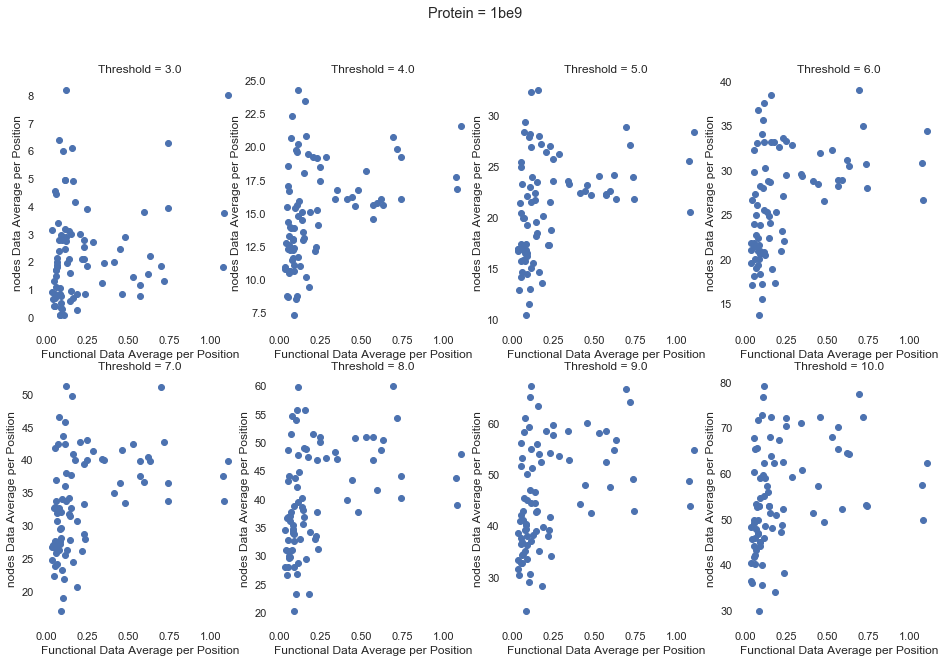

In [245]:
PlotAverages('1be9')

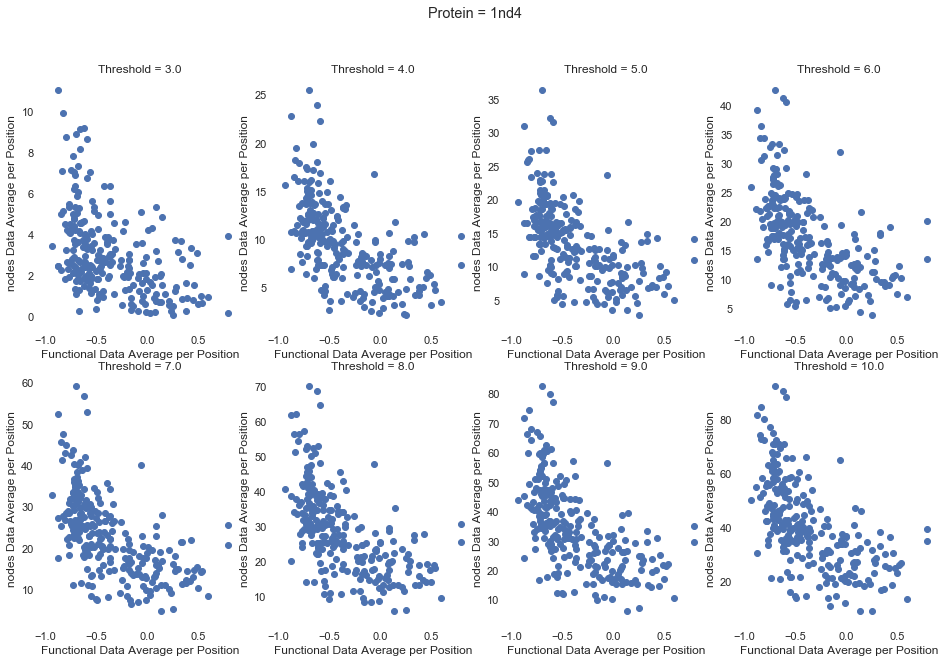

In [248]:
PlotAverages('1nd4')

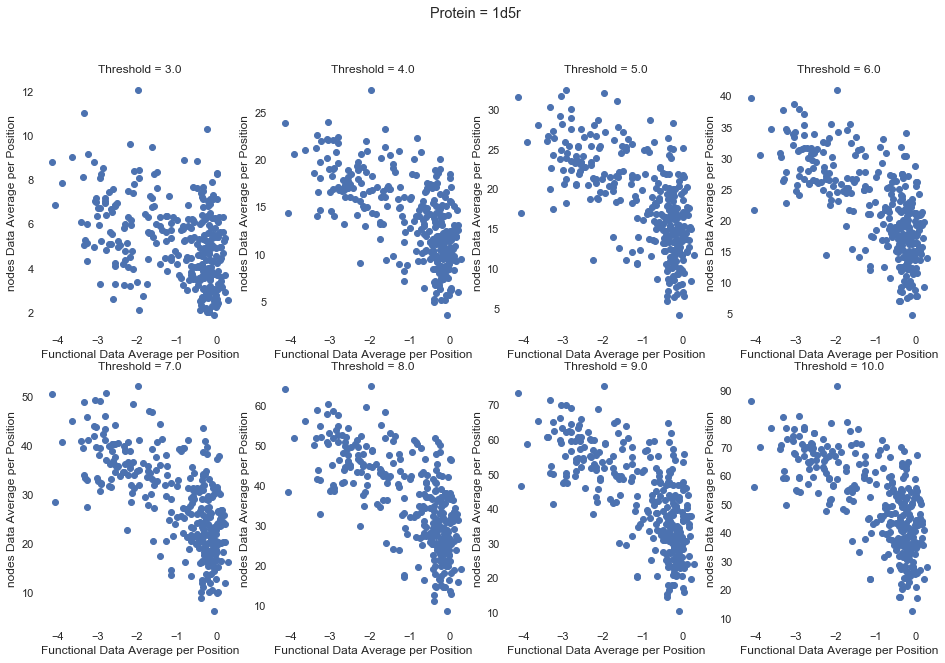

In [242]:
PlotAverages('1d5r')

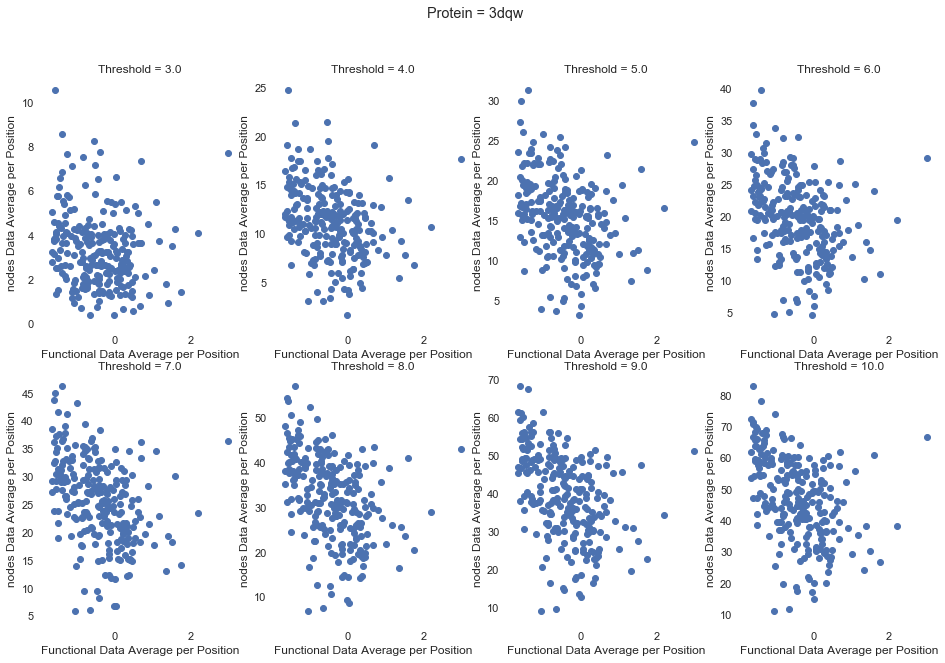

In [243]:
PlotAverages('3dqw')

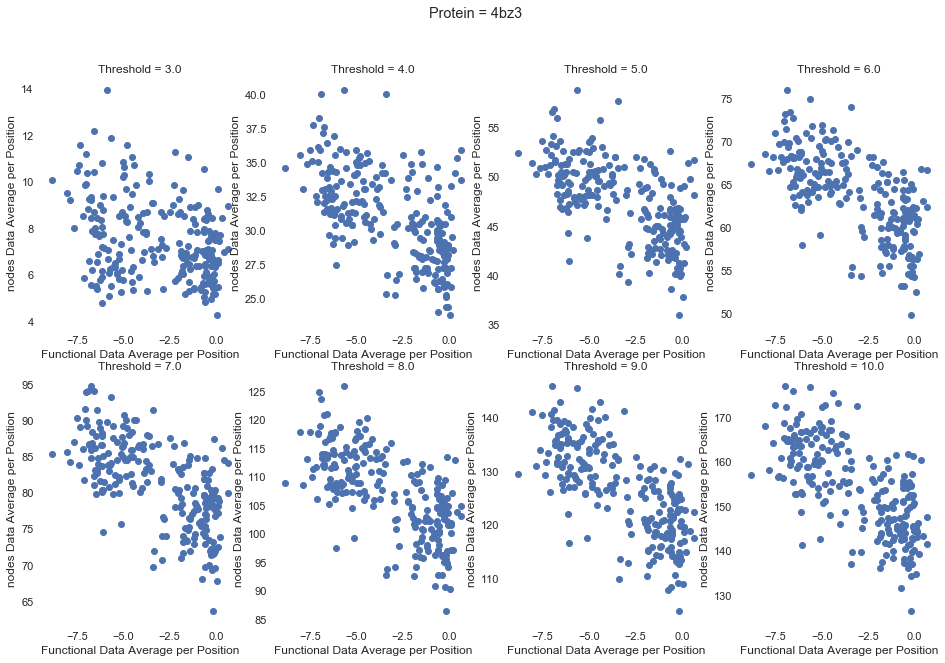

In [244]:
PlotAverages('4bz3')

Parece que si los valores de datos funcionales están tan bien distribuidos, se ve mucho mejor correlación lineal. Por ejemplo, 4bz3 y 1nd4 son buenos, pero un valor muy alto en 3dqw parece distorcionar mucho los valores para los números bajos. 1be9 y 1d5r parecen presentar más o menos el mismo problema, donde hay muchos valores pegados al principio y eso distorciona un poco los demás valores. Si todos los papers aplican las mismas funciones para obtener los valores (creo que todos usan logaritmos, tengo que checarlo. ¿Tal vez las bases lo están distorcionando?), podríamos aplicar la misma transformación a todos los valores para que estén mejor distribuidos. 

Probemos esa hipótesis quitando los outliers de 3dqw. 

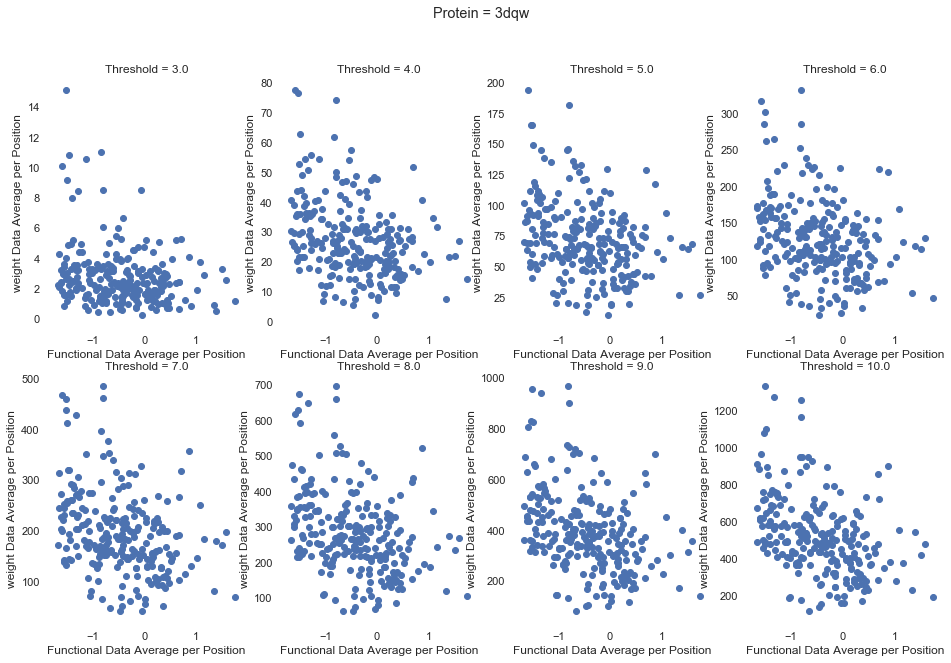

In [453]:
functional_average = list(functional_data['3dqw'].mean())
indices_to_delete = []
for i, x in enumerate(functional_average):
    if x > 2:
        indices_to_delete.append(i)
indices_to_delete.sort(reverse=True)
for i in indices_to_delete:
    del functional_average[i]
    
corr = pd.DataFrame(index=sample_thresholds, columns=['Pearson', 'Spearman'])
    
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Protein = 3dqw')
measure='weight'

for x, threshold in enumerate(sample_thresholds):
    network_df = ReadNetworkCSV('3dqw', threshold, measure)
    network_average = list(network_df.mean())
     
    for i in indices_to_delete:
        del network_average[i]
    
    corr.at[threshold, 'Pearson'] = round(sp.stats.pearsonr(functional_average, network_average)[0], 3)
    corr.at[threshold, 'Spearman'] = round(sp.stats.spearmanr(functional_average, network_average)[0], 3)
    
    ax = fig.add_subplot(2, 4, x+1)
    ax.set_facecolor('xkcd:white')
    plt.plot(functional_average, network_average, 'bo')
    plt.xlabel('Functional Data Average per Position')
    plt.ylabel(f'{measure} Data Average per Position')
    plt.title(f'Threshold = {threshold}')

In [250]:
corr

,Pearson,Spearman
3.0,-0.22,-0.212
4.0,-0.35,-0.367
5.0,-0.384,-0.407
6.0,-0.399,-0.413
7.0,-0.432,-0.458
8.0,-0.443,-0.477
9.0,-0.473,-0.501
10.0,-0.476,-0.503


Sigue sin mejorar demasiado... Es curioso que haya dos rangos de valores de correlación, y no estoy muy segura de qué hace diferentes a las dos proteínas con valores más bajos de las otras tres. 

No estoy muy segura de qué hacer sobre los valores absolutos, en los casos donde tenemos valores tanto positivos como negativos. Pensando más en el caso de 3dqw, donde aplicar valor absoluto baja un poco la correlación, es interesante que los valores con ganancia de función tienen valores más bajos en los nodos que los de pérdida de función con la misma magnitud. Supongo que la explicación biológica es que la proteína no puede mejorar demasiado cambiando su estructura, porque la estructura que ya tiene es muy buena. Eso me sugiere que es mejor trabajar con los valores normales y no los absolutos, pero en ese caso no sé qué hacer con 1be9. 

Creo que antes de seguir con las correlaciones por posición y mutación (que no sé qué tanta fe les tengo, porque las de las columnas no fueron tan ilustrativas), creo que sería interesante leer más sobre la forma de analizar los datos de las proteínas, por ejemplo, si algunas son log base 2 o base 10, y ver si eso arroja alguna diferencia clara entre las dos proteínas que tienen menor correlación. De cualquier manera creo que es claro que sí estamos obteniendo información de las gráficas. 

Tal vez sería interesante tomar las posiciones con el 10% (o 5% o algo) de valores más altos, y compararlas con las posiciones que los artículos identifican como más sensibles. Solo de ver las gráficas, parece que casi todos los valores altos corresponden a pérdidas de función significativas, lo cual tiene mucho sentido, pero que no siempre si el cambio funcional es grande, hay un cambio grande en las gráficas. Podríamos tomar los valores más altos para cada una de las métricas (weight, distance, nodes, edges), y tal vez al juntarlos eso nos dé una mejor predicción de las mutaciones sensibles (es decir, que con que una métrica sea alta, podemos decir que es sensible aunque las otras sean promedio). O, por ejemplo, ver si con que haya un aminoácido en una posición que dé valores altos en las gráficas, podemos decir que es una posición sensible aunque no necesariamente todos los aminoácidos en esa posición den valores altos. 

In [425]:
def PlotSpearman(protein, thresholds=thresholds):
    """Plot absolute value of Spearman correlation by threshold."""
    fig = plt.figure(figsize=(18,5))
    fig.suptitle(f'Protein = {protein}')
    values = SampleSpearmanR(protein, thresholds=thresholds)
    for x, measure in enumerate(measures):
        sp_values = [abs(values.at[threshold, measure]) for threshold in thresholds]
        ax = fig.add_subplot(1, 4, x+1)
        ax.set_facecolor('xkcd:white')
        ax.set_ylim([0,1])
        plt.plot(thresholds, sp_values, 'bo')
        plt.xlabel('Thresholds')
        plt.ylabel('Spearman Correlation')
        plt.title(f'Measure = {measure}')
        
    plt.show()
    return

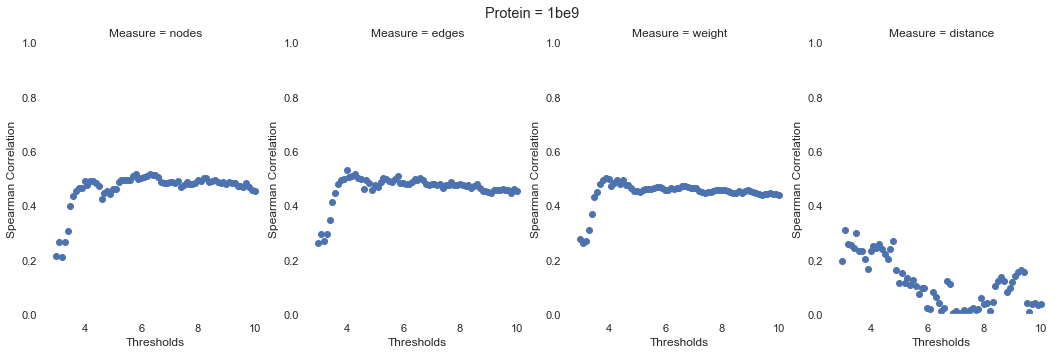

In [430]:
PlotSpearman('1be9')

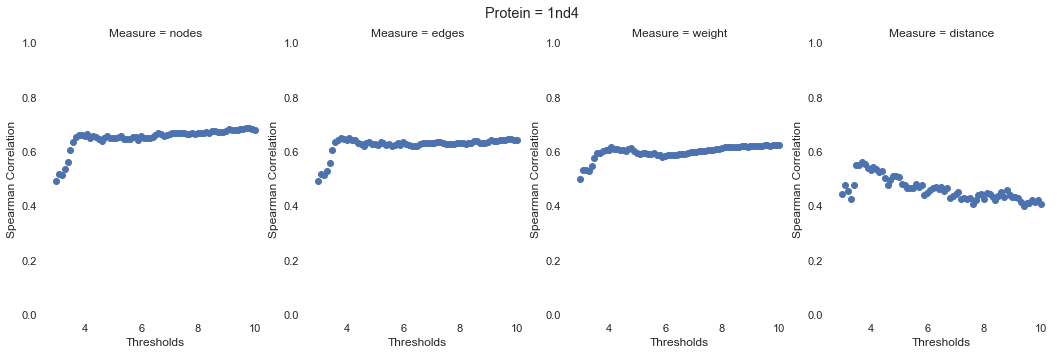

In [431]:
PlotSpearman('1nd4')

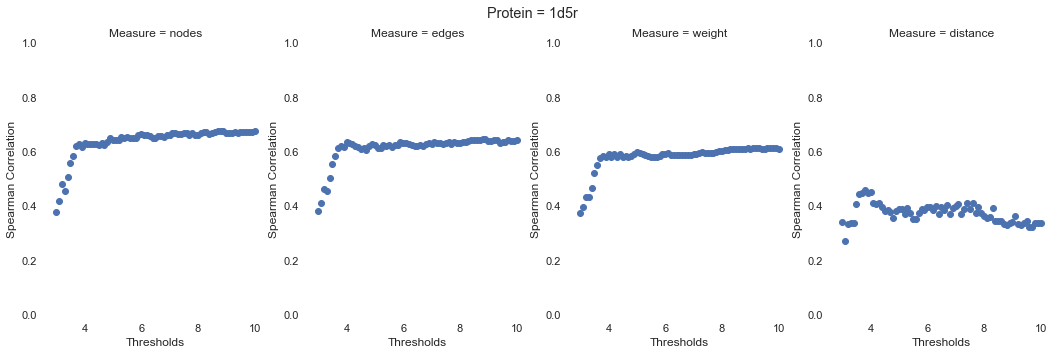

In [426]:
PlotSpearman('1d5r')

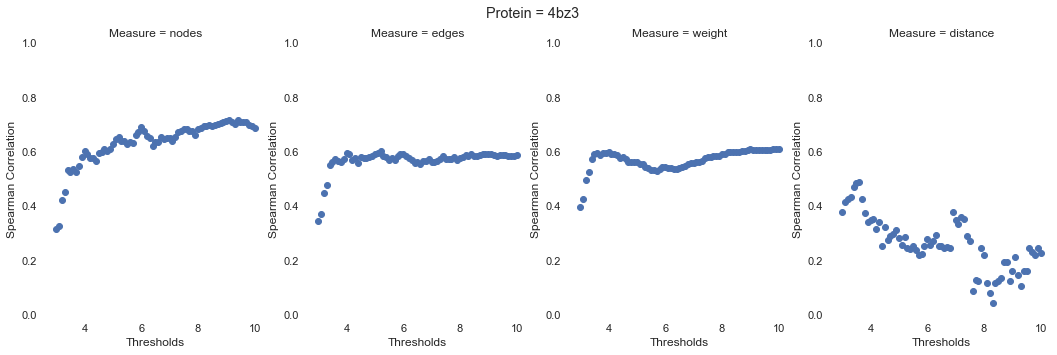

In [427]:
PlotSpearman('4bz3')

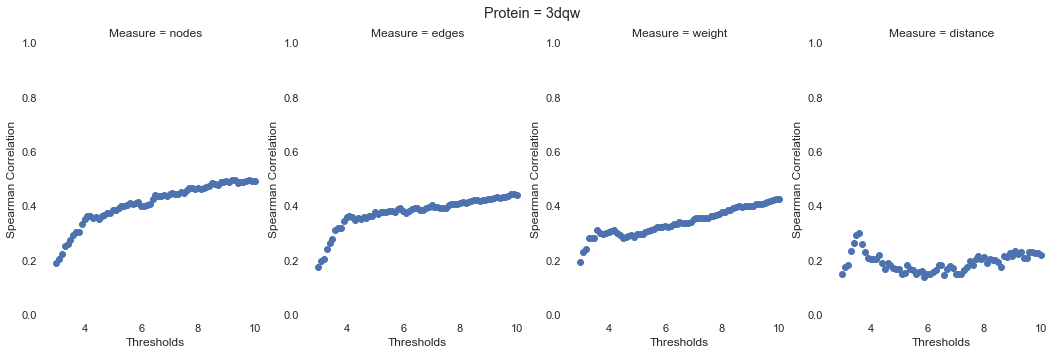

In [428]:
PlotSpearman('3dqw')

Parece que la mejor medida son los nodos. Se ve muy clara la distinción con thresholds arriba de 4.0, para algunas se mantiene al llegar ahí, y para otras sigue creciendo. Creo que 9.0 o 10.0 es un buen threshold para referencia. Es interesante cómo cambia la distancia, y que su pico es alrededor de 3.5-3.8. 

In [341]:
# Standardize functional data, store resulting dataframes in standardized_data
standardized_data = dict()
for protein in proteins:
    data = functional_data[protein]
    data_array = data.to_numpy()
    data_mean = np.nanmean(data, dtype=np.float64)
    data_std = np.nanstd(data, dtype=np.float64)
    data = data.apply(lambda x:(x-data_mean)/data_std)
    standardized_data[protein] = data

No sé si los datos de las gráficas deberíamos normalizarlos a 0-1 o a una gaussiana, siento que el 0 debería seguir siendo 0, porque justo representa que no hay cambio. Pero en ese caso, definir las posiciones sensibles no es tan fácil como los datos funcionales (donde nos basaríamos en desviaciones estándar). En los heatmaps se ve que estandarizar con los ceros afecta la distribución de los otros valores, y para poder identificar las posiciones con cambios, hay que estandarizar sin los ceros. 

Intenté tomar solo los que tenían valores muy altos en sus redes, pero creo que algo más ilustrativo sería comparar los que están arriba del promedio en datos funcionales con los que están abajo del promedio en las redes de perturbación, y vice versa.  

Quitar los ceros no cambia las correlaciones (supongo que por ser transformación lineal?), pero creo que ayudará a identificar nuestras posiciones sensibles. Por los heatmaps, el efecto en las otras proteínas no era tanto, pero igual creo que era importante notarlo y hacer las comparaciones con estos datos. 

En ambos casos, redes y datos funcionales, creo que hace cosas algo extrañas el estandarizar con el promedio a cero, siento que importa mucho más la distancia de un valor a cero, que la distancia de un valor al cambio promedio, pero no sé cómo normalizar de forma que podamos trabajar con las desviaciones estándar pero no perder la información de estar arriba o abajo del cero (¿tal vez estandarizar sin restar la media?).

In [455]:
def RemoveZeros(protein, threshold, measure):
    df = ReadNetworkCSV(protein, threshold, measure)
    for position in df.columns:
        for aa in df.index:
            if position[0] == aa:
                df.at[aa, position] = np.nan
    return df

In [478]:
def Standardize(protein, threshold, measure, function=RemoveZeros):
    """Return standardized values from network data."""
    data = function(protein, threshold, measure)
    data_array = data.to_numpy()
    data_mean = np.nanmean(data, dtype=np.float64)
    data_std = np.nanstd(data, dtype=np.float64)
    data = data.apply(lambda x:(x-data_mean)/data_std)
    return data 

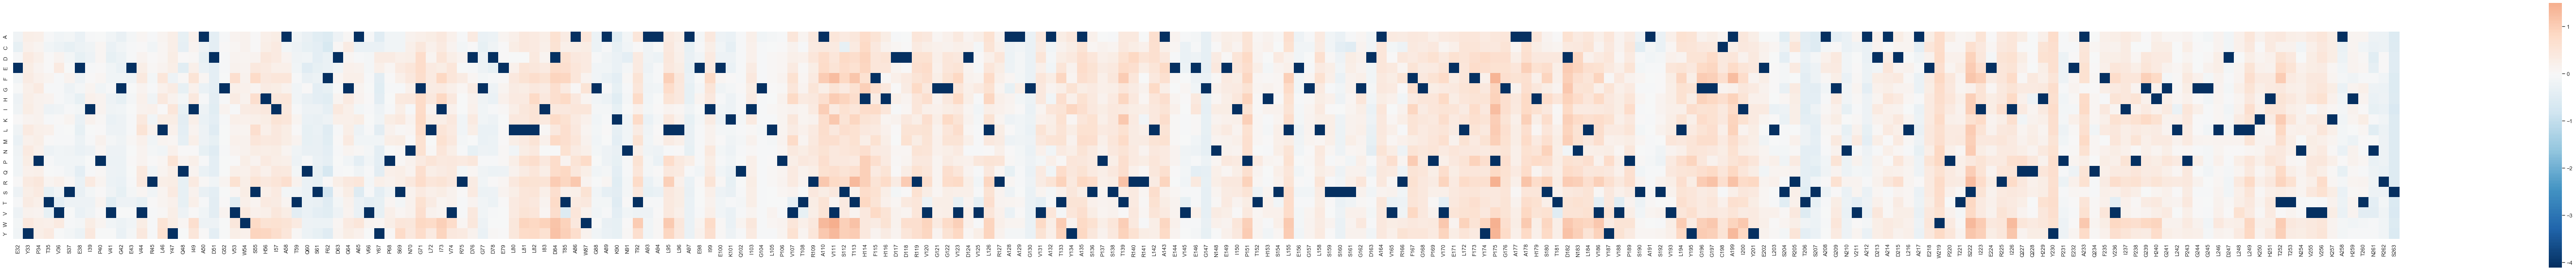

In [479]:
PlotHeatmap(Standardize('4bz3', 9.0, 'nodes', function=ReadNetworkCSV))

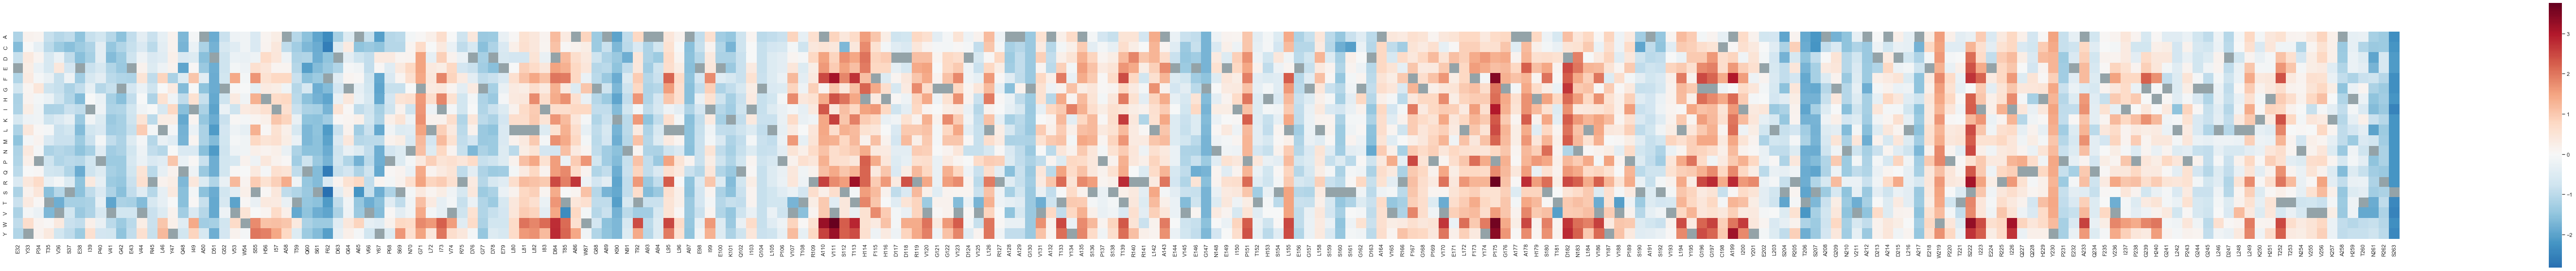

In [480]:
PlotHeatmap(Standardize('4bz3', 9.0, 'nodes'))

In [534]:
# Compare number of positions one and two standard deviations from mean (functional data)
# Consider average from all mutations in one position 
extreme_values = pd.DataFrame(index=proteins, columns=['1 std','% 1 std', '1.5 std', '% 1.5 std', '2 std', '% 2 std'])
for protein in proteins:
    data = standardized_data[protein]
    data_mean = list(data.mean())
    n = len(data_mean)
    how_many_1 = 0
    how_many_15 = 0
    how_many_2 = 0
    for value in data_mean:
        #if value > 1 or value < -1:
        if value < -1:
            how_many_1 += 1
        #if value > 1.5 or value < -1.5:
        if value < -1.5:
            how_many_15 += 1
        #if value > 2 or value < -2:
        if value < -2:
            how_many_2 += 1
    extreme_values.at[protein, '1 std'] = how_many_1  
    extreme_values.at[protein, '1.5 std'] = how_many_15  
    extreme_values.at[protein, '2 std'] = how_many_2 
    extreme_values.at[protein, '% 1 std'] = str(round(100*how_many_1/n, 1))+'%' 
    extreme_values.at[protein, '% 1.5 std'] = str(round(100*how_many_15/n, 1))+'%' 
    extreme_values.at[protein, '% 2 std'] = str(round(100*how_many_2/n, 1))+'%'
extreme_values

,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std
1be9,0,0.0%,0,0.0%,0,0.0%
1d5r,49,16.0%,13,4.2%,2,0.7%
1nd4,0,0.0%,0,0.0%,0,0.0%
3dqw,30,12.4%,0,0.0%,0,0.0%
4bz3,34,14.7%,2,0.9%,0,0.0%


Parecen estar distribuidas similarmente, sin embargo, hay muy pocas lejos del promedio. Para tener suficientes para identificar las posiciones sensibles, creo que tendríamos que considerar las que están a 1 desviación estándar. 

In [490]:
# Repeat for standardized network data, taking nodes as measurement, 9.0 as threshold
extreme_values = pd.DataFrame(index=proteins, columns=['1 std','% 1 std', '1.5 std', '% 1.5 std', '2 std', '% 2 std'])
for protein in proteins:
    data = Standardize(protein, 9.0, 'nodes')
    data_mean = list(data.mean())
    n = len(data_mean)
    how_many_1 = 0
    how_many_15 = 0
    how_many_2 = 0
    for value in data_mean:
        if value > 1:
            how_many_1 += 1
        if value > 1.5:
            how_many_15 += 1
        if value > 2:
            how_many_2 += 1
    extreme_values.at[protein, '1 std'] = how_many_1  
    extreme_values.at[protein, '1.5 std'] = how_many_15  
    extreme_values.at[protein, '2 std'] = how_many_2 
    extreme_values.at[protein, '% 1 std'] = str(round(100*how_many_1/n, 1))+'%' 
    extreme_values.at[protein, '% 1.5 std'] = str(round(100*how_many_15/n, 1))+'%' 
    extreme_values.at[protein, '% 2 std'] = str(round(100*how_many_2/n, 1))+'%'
extreme_values

,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std
1be9,15,18.1%,5,6.0%,0,0.0%
1d5r,48,15.6%,9,2.9%,2,0.7%
1nd4,38,14.9%,18,7.1%,6,2.4%
3dqw,27,11.2%,7,2.9%,2,0.8%
4bz3,31,13.4%,6,2.6%,0,0.0%


In [532]:
# Check intersection between functional data above/below 1 std, and sample network data above/below 1 std. 
# percentage represents true positives, how many functionally sensible values could we identify
# Gain of function = higher than average functional values, loss of function lower than average 
extreme_values = pd.DataFrame(index=proteins, columns=['Gain of function','% gain', 'Loss of function', '% loss'])
for protein in proteins:
    network_df = Standardize(protein, 9.0, 'nodes')
    functional_df = standardized_data[protein]
    
    network_mean = list(network_df.mean())
    functional_mean = list(functional_df.mean())
    
    network_extremes_above = set()
    network_extremes_below = set()
    functional_extremes_above = set()
    functional_extremes_below = set()
    
    for i,position in enumerate(list(network_df.columns)):
        value = network_mean[i]
        if value > 1:
            network_extremes_above.add(position)
        elif value < -1:
            network_extremes_below.add(position)
    for i,position in enumerate(list(functional_df.columns)):
        value = functional_mean[i]
        if value > 1:
            functional_extremes_above.add(position)
        elif value < -1:
            functional_extremes_below.add(position)
    
    how_many_gain = len(network_extremes_below.intersection(functional_extremes_above))
    how_many_loss = len(network_extremes_above.intersection(functional_extremes_below))
    
    total_gain = len(functional_extremes_above)
    total_loss = len(functional_extremes_below)

    extreme_values.at[protein, 'Gain of function'] = how_many_gain
    extreme_values.at[protein, 'Loss of function'] = how_many_loss
    
    if total_gain != 0:
        extreme_values.at[protein, '% gain'] = str(round(100*how_many_gain/total_gain, 1))+'%' 
   
    if total_loss != 0:
        extreme_values.at[protein, '% loss'] = str(round(100*how_many_loss/total_loss, 1))+'%' 

extreme_values

,Gain of function,% gain,Loss of function,% loss
1be9,0,0.0%,0,NaN
1d5r,0,NaN,28,57.1%
1nd4,8,30.8%,0,NaN
3dqw,3,15.8%,11,36.7%
4bz3,2,18.2%,14,41.2%


No aplica para 1be9, por los valores absolutos, pero parece funcionar más o menos bien. Sin considerar la distinción entre positivos y negativos, encontramos dos de las posiciones sensibles de 1be9. 

In [521]:
extreme_values = pd.DataFrame(index=proteins, columns=['Intersection','%'])
for protein in proteins:
    network_df = Standardize(protein, 9.0, 'nodes')
    functional_df = standardized_data[protein]
    
    network_mean = list(network_df.mean())
    functional_mean = list(functional_df.mean())
    
    network_extremes = set()
    functional_extremes = set()
    
    for i,position in enumerate(list(network_df.columns)):
        value = network_mean[i]
        if value > 1 or value < -1:
            network_extremes.add(position)
    for i,position in enumerate(list(functional_df.columns)):
        value = functional_mean[i]
        if value > 1 or value < -1:
            functional_extremes.add(position)
    
    how_many = len(network_extremes.intersection(functional_extremes))
    total = len(functional_extremes)
    extreme_values.at[protein, 'Intersection'] = how_many
    extreme_values.at[protein, '%'] = str(round(100*how_many/total, 1))+'%' 

extreme_values

,Intersection,%
1be9,2,22.2%
1d5r,28,57.1%
1nd4,8,30.8%
3dqw,14,28.6%
4bz3,16,35.6%


Pasa algo muy extraño con 1nd4, parece que al estandarizar, todas las posiciones con pérdida de función se quedan abajo del 1, y no podemos sacarlas para comparar. Cuando tomamos valores negativos de las gráficas (muy poco cambio), identificamos algunas de las posiciones que tienen ganancia de función (o eso creo). No sé si sea algo causado por outliers, porque estamos tomando promedios, y no sé si tenga que ver con los datos funcionales, que están con base 10... 

En 1d5r, no encontramos o no hay posiciones una desviación estándar arriba del promedio. Igual, no estoy muy segura si deberíamos intentar encontrar las de ganancia de función, porque el que cambie poco es más sugestivo de que sea muy parecido al promedio, no más arriba. Sin embargo, creo que sí hay que hacer la distinción de considerar 

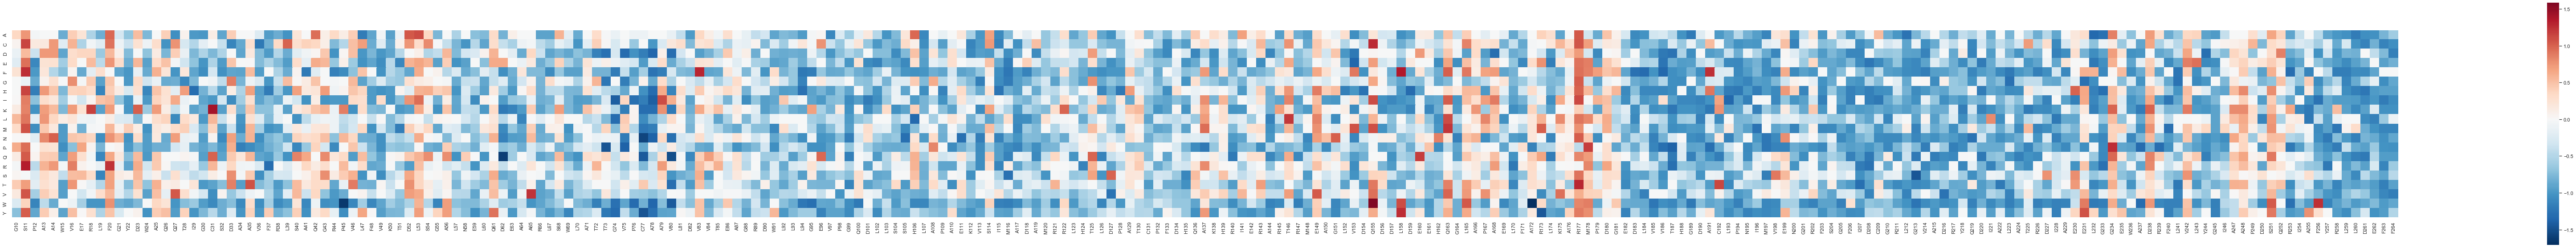

In [497]:
PlotHeatmap(functional_1nd4)

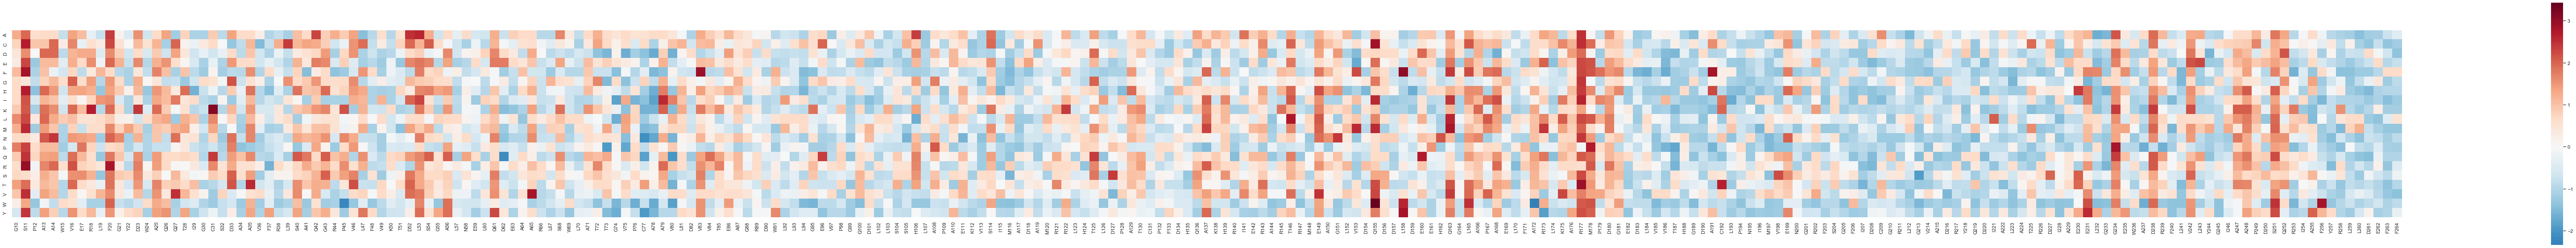

In [517]:
PlotHeatmap(standardized_data['1nd4'])

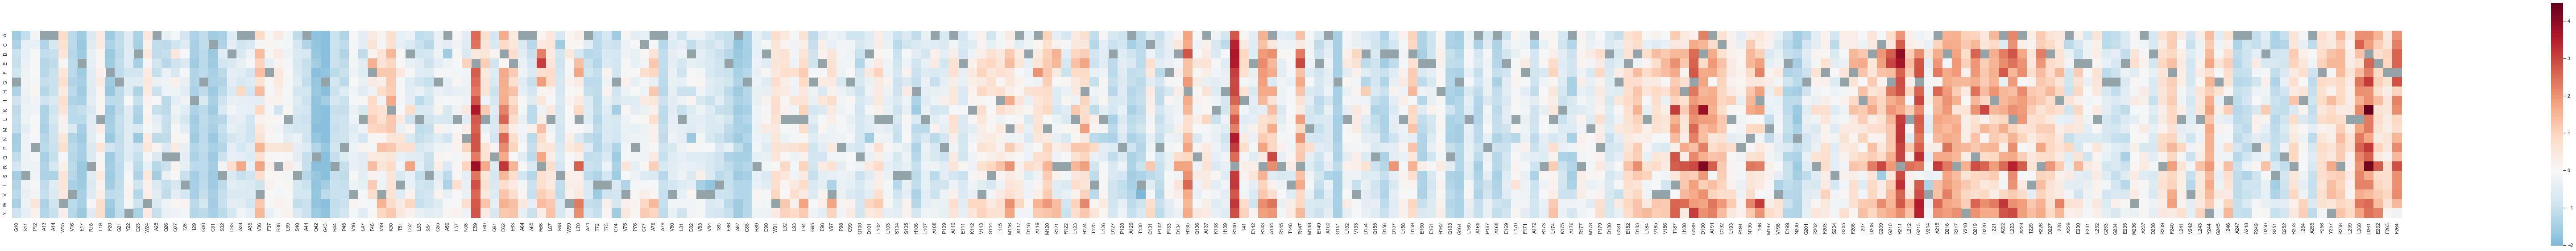

In [496]:
PlotHeatmap(Standardize('1nd4', 9.0, 'nodes'))

In [528]:
for i in standardized_data['1nd4'].mean():
    if i < -1:
        print(i)

Creo que en los datos funcionales, sí tiene sentido tomar el promedio de los puntajes, pero en las gráficas, con que un aminoácido tenga una red de perturbación muy distinta ya sugiere que es una posición sensible. Podemos checar si considerar las posiciones con al menos una mutación sensible no nos deja una cantidad demasiado grande de posiciones posibles. 

Probaremos comparando valores negativos de función con valores altos de redes de perturbación. Tres proteínas tienen valores funcionales estandarizados abajo de -1, vemos primero cómo están distribuidos los valores de las gráficas para esas tres. 

In [542]:
# Check distribution when selecting positions based on whether a single mutation is above/below number of std
extreme_values = pd.DataFrame(index=['1d5r', '3dqw','4bz3'], columns=['1 std','% 1 std', '1.5 std', '% 1.5 std', '2 std', '% 2 std'])
for protein in ['1d5r', '3dqw','4bz3']:
    data = Standardize(protein, 9.0, 'nodes')
    which_1 = set()
    which_15 = set()
    which_2 = set()
    
    n = len(data.columns)
    for column in data.columns:
        for aa in data.index:
            value = data.at[aa, column]
            if value > 1:
                which_1.add(column)
            if value > 1.5:
                which_15.add(column)
            if value > 2:
                which_2.add(column)
    extreme_values.at[protein, '1 std'] = len(which_1) 
    extreme_values.at[protein, '1.5 std'] = len(which_15)
    extreme_values.at[protein, '2 std'] = len(which_2)
    extreme_values.at[protein, '% 1 std'] = str(round(100*len(which_1)/n, 1))+'%' 
    extreme_values.at[protein, '% 1.5 std'] = str(round(100*len(which_15)/n, 1))+'%' 
    extreme_values.at[protein, '% 2 std'] = str(round(100*len(which_2)/n, 1))+'%'
extreme_values

,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std
1d5r,140,45.6%,104,33.9%,63,20.5%
3dqw,120,49.6%,79,32.6%,47,19.4%
4bz3,102,44.2%,78,33.8%,42,18.2%


In [555]:
# Select possible sensitive positions if at least one mutation is above threshold 
for std in [1, 1.5, 2]:
    extreme_values = pd.DataFrame(index=['1d5r', '3dqw','4bz3'], columns=['True Positives', 'True Positive Rate', 
                                                                      'False Positives'])
    for protein in ['1d5r', '3dqw','4bz3']:
        network_df = Standardize(protein, 9.0, 'nodes')
        functional_df = standardized_data[protein]
        functional_mean = list(functional_df.mean())

        network_extremes = set()
        functional_extremes = set()

        for column in network_df.columns:
            for aa in network_df.index:
                network_value = network_df.at[aa, column]
                if network_value > std:
                    network_extremes.add(column)

        for i,position in enumerate(list(functional_df.columns)):
            value = functional_mean[i]
            if value < -1:
                functional_extremes.add(position)

        how_many = len(network_extremes.intersection(functional_extremes))
        
        extreme_values.at[protein, 'True Positives'] = how_many
        extreme_values.at[protein, 'True Positive Rate'] = str(round(100*how_many/len(functional_extremes), 1))+'%' 
        extreme_values.at[protein, 'False Positives'] = len(network_extremes) - how_many 
    
    print(f'sd = {std}')
    display(extreme_values)

sd = 1


,True Positives,True Positive Rate,False Positives
1d5r,47,95.9%,93
3dqw,25,83.3%,95
4bz3,32,94.1%,70


sd = 1.5


,True Positives,True Positive Rate,False Positives
1d5r,39,79.6%,65
3dqw,21,70.0%,58
4bz3,29,85.3%,49


sd = 2


,True Positives,True Positive Rate,False Positives
1d5r,33,67.3%,30
3dqw,15,50.0%,32
4bz3,17,50.0%,25


Ignorando ahorita los falsos positivos (que dijimos que eran y no eran), cubrimos mejor los que sí son. 2 desviaciones nos da un porcentaje un poco más alto de posiciones, pero más o menos parecido al porcentaje de valores con cambio funcional con el que comparamos. Igual hay que checar si los que consideramos como falsos positivos se quedan cerca del corte de score < -1, o si se quedan lejos. 

Creo que sería importante estandarizar manteniendo los ceros como ceros, que creo que se logra solo dividiendo entre la desviación estándar. Nos ayudaría a distinguir mejor los que están abajo, que son los que es más fácil predecir con los datos que tenemos. Lo escribí en alguna parte, pero siento que afecta mucho más la distancia al cero que la distancia al promedio, y creo que sería más fácil poder identificar las posiciones sensibles en ese caso. 